Loading data...
Historical cities: ['Beijing', 'Berlin', 'Boston', 'London', 'Paris', 'Tokyo']
Forecast cities: ['Beijing', 'Berlin', 'Boston', 'London', 'Paris', 'Tokyo']
Model results cities: ['Beijing', 'Berlin', 'Boston', 'London', 'Paris', 'Tokyo']

Final cities being processed: ['Boston', 'Paris', 'Beijing', 'Tokyo', 'Berlin', 'London']

Creating comprehensive forecast visualization...


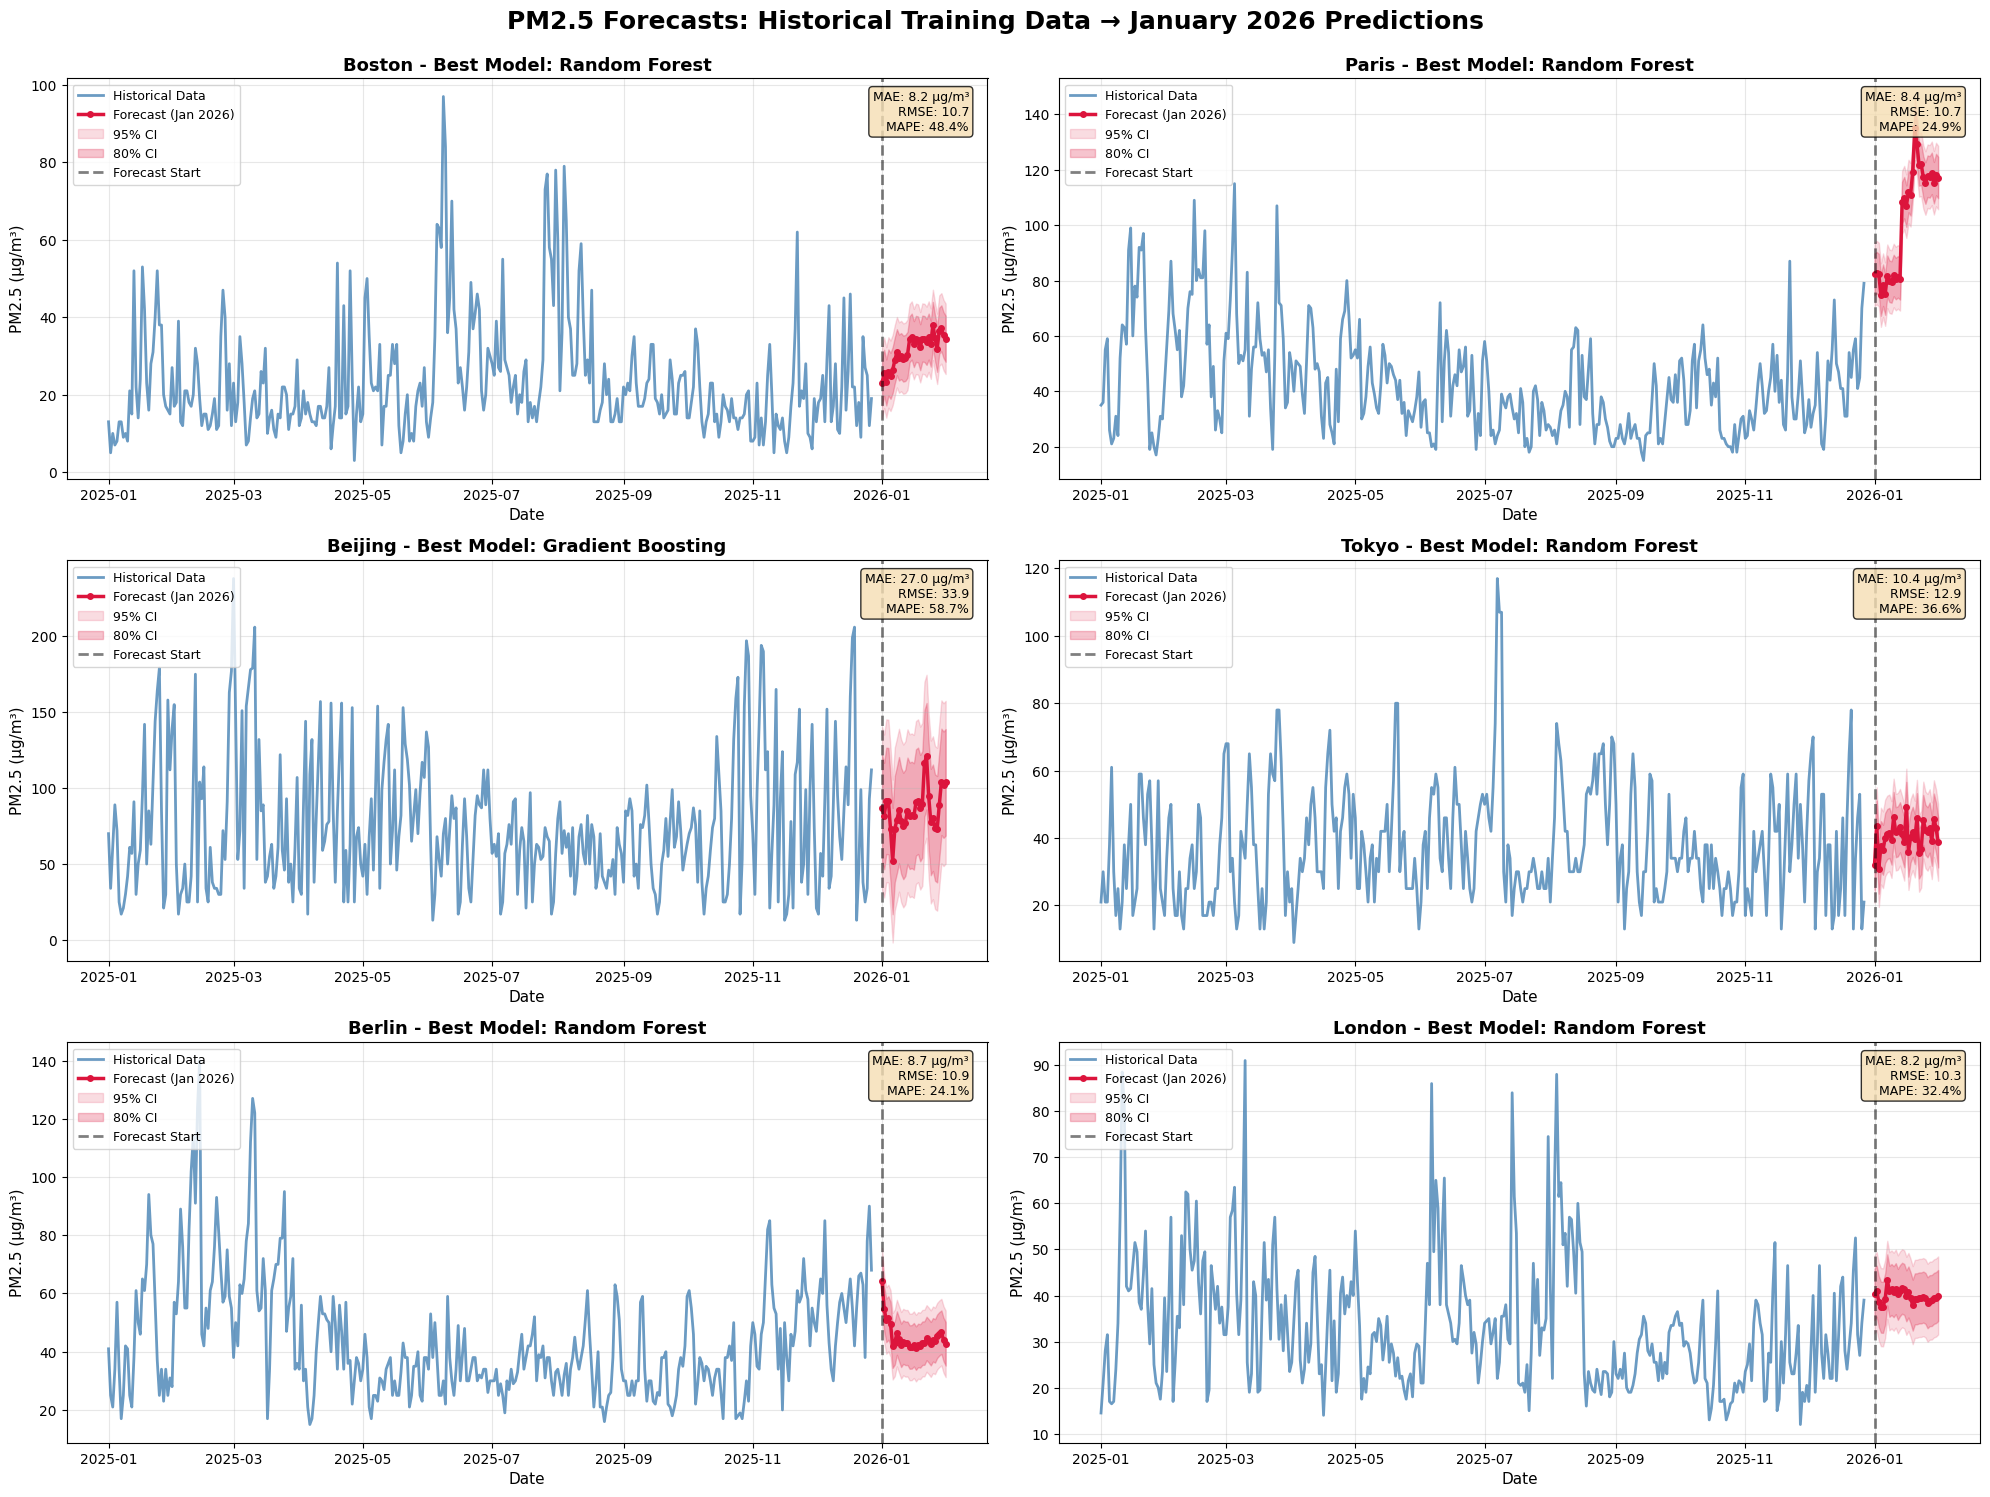


ANALYSIS: Understanding MAPE and Forecast Patterns

Boston:
  Best Model: Random Forest
  MAE: 8.20 | RMSE: 10.65 | MAPE: 48.4%
  Historical: μ=27.3, σ=12.4, range=[3.0, 97.0]
  Forecast:   μ=31.6, σ=4.1
  ⚠️  High MAPE (>25%) - challenging to forecast

Paris:
  Best Model: Random Forest
  MAE: 8.35 | RMSE: 10.66 | MAPE: 24.9%
  Historical: μ=45.2, σ=21.0, range=[10.0, 164.0]
  Forecast:   μ=101.7, σ=19.5
  ⚠️  WARNING: Forecast mean (101.7) differs significantly from historical (45.2)
  ✓ Good MAPE (15-25%)

Beijing:
  Best Model: Gradient Boosting
  MAE: 27.02 | RMSE: 33.94 | MAPE: 58.7%
  Historical: μ=97.2, σ=57.2, range=[9.0, 469.0]
  Forecast:   μ=86.1, σ=13.6
  ⚠️  WARNING: Forecast variance (13.6) much lower than historical (57.2)
      → Model is over-smoothing! Missing volatility.
  ⚠️  High MAPE (>25%) - challenging to forecast

Tokyo:
  Best Model: Random Forest
  MAE: 10.45 | RMSE: 12.90 | MAPE: 36.6%
  Historical: μ=40.4, σ=17.6, range=[1.0, 117.0]
  Forecast:   μ=40.7, 

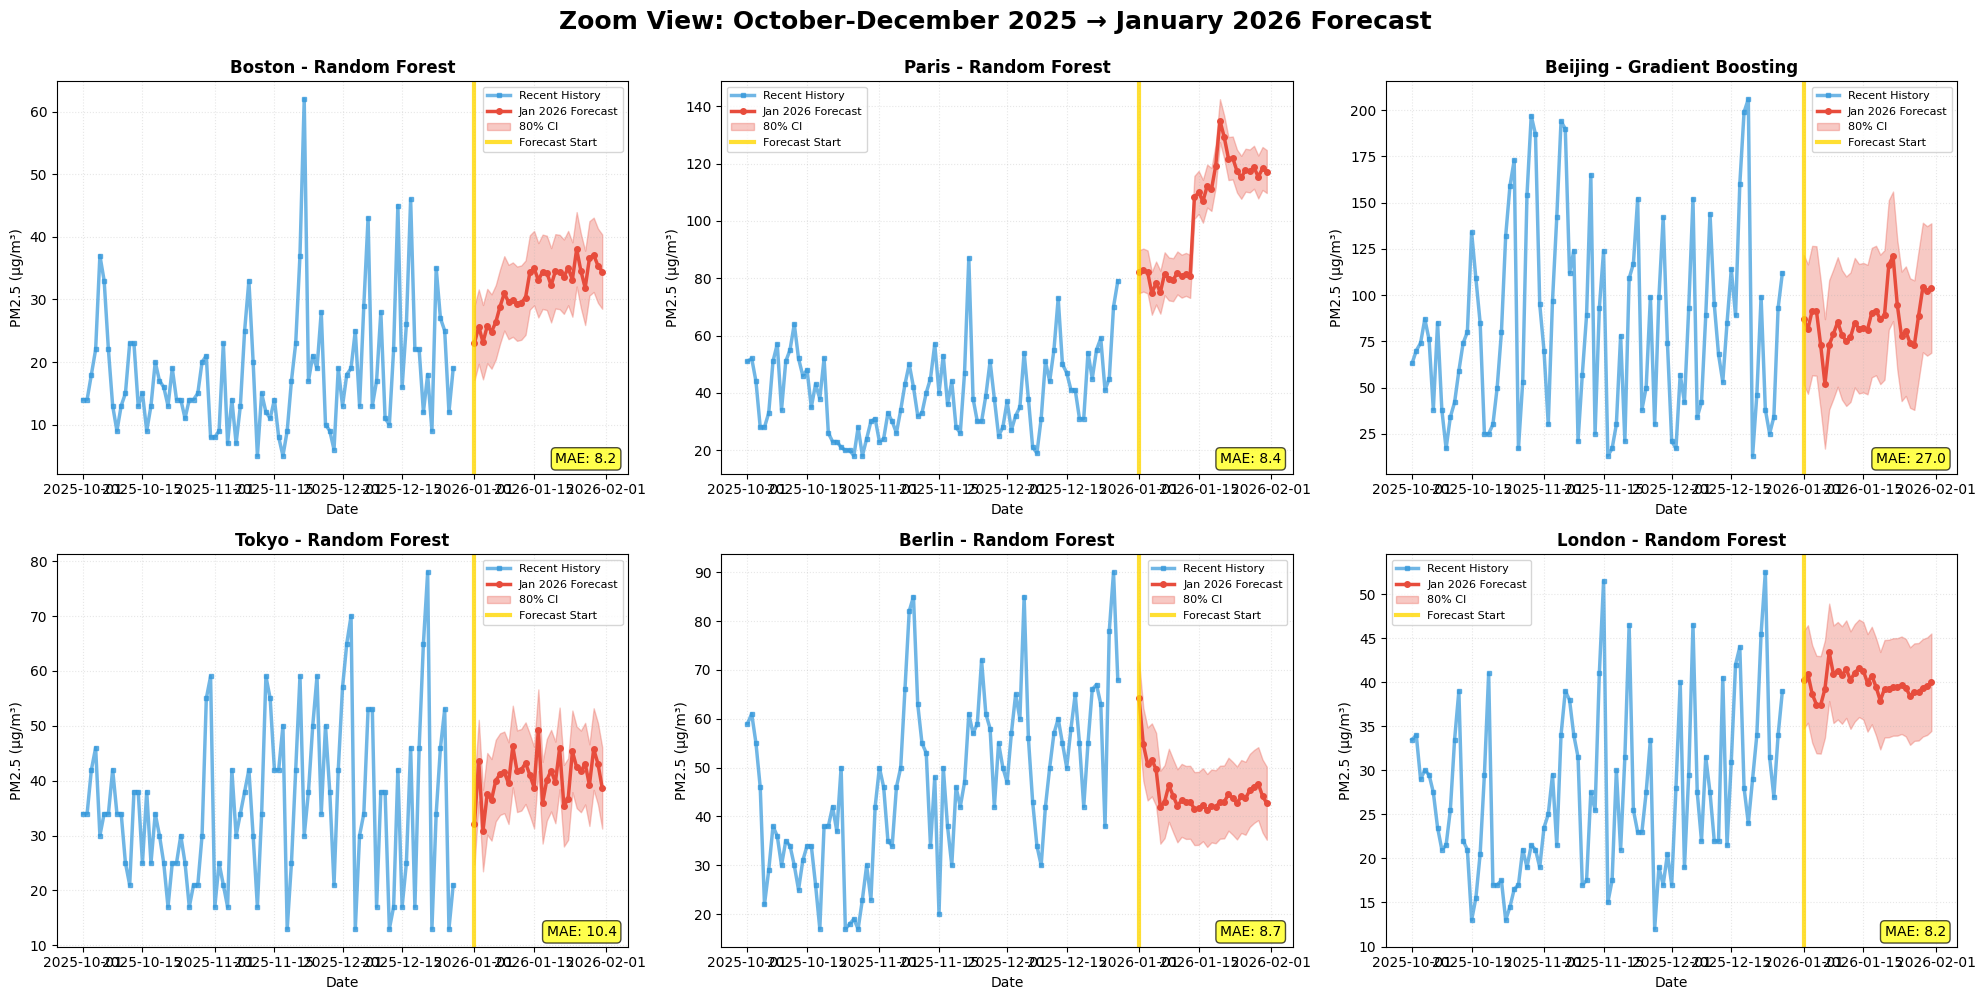

Creating performance summary...


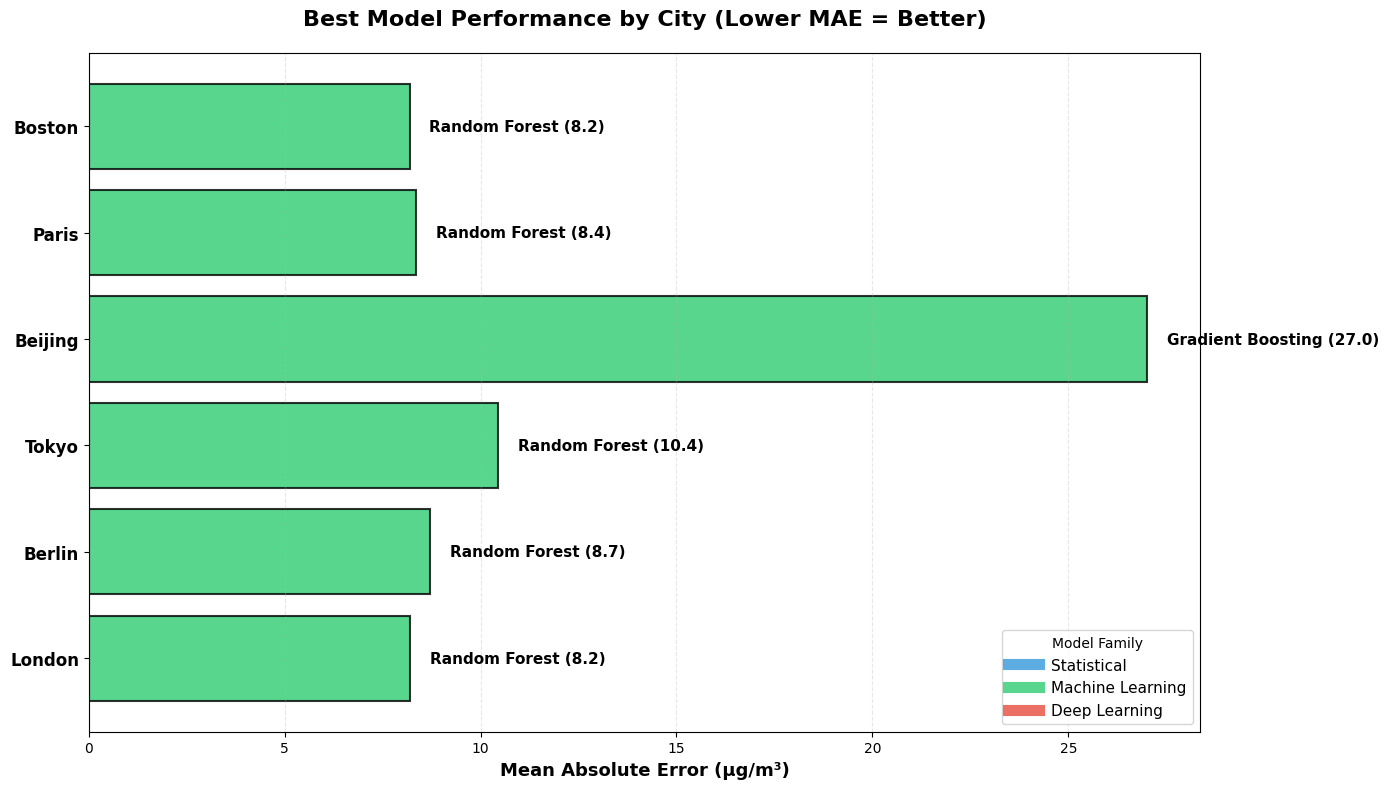


FORECAST SUMMARY

City            Best Model           MAE        RMSE       MAPE       Avg Forecast   
------------------------------------------------------------------------------------------
Boston          Random Forest        8.2        10.7       48.4%      31.6           
Paris           Random Forest        8.4        10.7       24.9%      101.7          
Beijing         Gradient Boosting    27.0       33.9       58.7%      86.1           
Tokyo           Random Forest        10.4       12.9       36.6%      40.7           
Berlin          Random Forest        8.7        10.9       24.1%      45.1           
London          Random Forest        8.2        10.3       32.4%      39.9           

✓ All visualizations saved to: c:\Users\klevi\Desktop\Time Series Analysis\Air_Quality_Index-CAPSTONE_PROJECT\outputs
  - all_forecasts_with_training.png
  - detailed_forecast_[city].png (6 files)
  - zoom_forecast_view.png
  - performance_summary_clean.png



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# --- CONFIGURATION ---
BASE_DIR = os.path.dirname(os.getcwd())
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
PREDICTIONS_DIR = os.path.join(BASE_DIR, "predictions")
FORECAST_FILE = os.path.join(BASE_DIR, "data", "processed", "forecast_ready.parquet")
MODEL_COMPARISON_FILE = os.path.join(OUTPUT_DIR, 'model_comparison.json')

# Target cities (your specific list)
TARGET_CITIES = ["Boston", "Paris", "Beijing", "Tokyo", "Berlin", "London"]

# Load data
print("Loading data...")
historical = pd.read_parquet(FORECAST_FILE)
forecasts = pd.read_parquet(os.path.join(PREDICTIONS_DIR, 'pm25_forecast_2026_01.parquet'))
historical['Date'] = pd.to_datetime(historical['Date'])
forecasts['Date'] = pd.to_datetime(forecasts['Date'])

# Filter for target cities only
historical = historical[historical['City'].isin(TARGET_CITIES)]
forecasts = forecasts[forecasts['City'].isin(TARGET_CITIES)]

print(f"Historical cities: {historical['City'].unique().tolist()}")
print(f"Forecast cities: {forecasts['City'].unique().tolist()}")

with open(MODEL_COMPARISON_FILE, 'r') as f:
    model_results = json.load(f)

print(f"Model results cities: {list(model_results.keys())}")

# Use only cities that exist in all datasets
cities = [city for city in TARGET_CITIES if city in model_results.keys() 
          and city in historical['City'].values 
          and city in forecasts['City'].values]

print(f"\nFinal cities being processed: {cities}")

if len(cities) == 0:
    print("\nERROR: No matching cities found!")
    print("Please check that city names match exactly across all files.")
    exit()

# Organize models by family
statistical_models = ['ARIMA', 'SARIMA', 'Exp Smoothing']
ml_models = ['Random Forest', 'Gradient Boosting', 'SVR']
dl_models = ['LSTM', 'GRU', 'CNN-LSTM']

# Color schemes
colors_stat = ['#3498db', '#2980b9', '#1f618d']
colors_ml = ['#2ecc71', '#27ae60', '#229954']
colors_dl = ['#e74c3c', '#c0392b', '#a93226']

# --- 1. COMPREHENSIVE 6-CITY FORECAST OVERVIEW ---
print("\nCreating comprehensive forecast visualization...")

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for idx, city in enumerate(cities):
    ax = axes[idx]
    
    # Get historical data (show last 12 months for context)
    hist_city = historical[historical['City'] == city].sort_values('Date')
    hist_recent = hist_city[hist_city['Date'] >= '2025-01-01']
    
    # Get forecast
    fcst_city = forecasts[forecasts['City'] == city].sort_values('Date')
    
    # Plot historical data
    ax.plot(hist_recent['Date'], hist_recent['median'], 
            color='steelblue', linewidth=2, label='Historical Data', alpha=0.8)
    
    # Plot forecast
    ax.plot(fcst_city['Date'], fcst_city['Prediction'], 
            color='crimson', linewidth=2.5, label='Forecast (Jan 2026)', marker='o', markersize=4)
    
    # Prediction intervals
    ax.fill_between(fcst_city['Date'], fcst_city['Lower_95'], fcst_city['Upper_95'],
                     alpha=0.15, color='crimson', label='95% CI')
    ax.fill_between(fcst_city['Date'], fcst_city['Lower_80'], fcst_city['Upper_80'],
                     alpha=0.25, color='crimson', label='80% CI')
    
    # Add vertical line at forecast start
    ax.axvline(x=pd.Timestamp('2026-01-01'), color='black', linestyle='--', 
               linewidth=2, alpha=0.5, label='Forecast Start')
    
    # Styling
    ax.set_title(f'{city} - Best Model: {model_results[city]["best_model"]}', 
                fontsize=13, fontweight='bold')
    ax.set_ylabel('PM2.5 (µg/m³)', fontsize=11)
    ax.set_xlabel('Date', fontsize=11)
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3)
    
    # Add performance metrics as text box
    mae = model_results[city]['all_scores'][model_results[city]['best_model']]['mae']
    rmse = model_results[city]['all_scores'][model_results[city]['best_model']]['rmse']
    mape = model_results[city]['all_scores'][model_results[city]['best_model']]['mape']
    
    textstr = f'MAE: {mae:.1f} µg/m³\nRMSE: {rmse:.1f}\nMAPE: {mape:.1%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right', bbox=props)

# Hide unused subplots if less than 6 cities
for idx in range(len(cities), 6):
    axes[idx].axis('off')

plt.suptitle('PM2.5 Forecasts: Historical Training Data → January 2026 Predictions', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'all_forecasts_with_training.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- 2. ANALYSIS: Why do low MAPE models look weird? ---
print("\n" + "="*80)
print("ANALYSIS: Understanding MAPE and Forecast Patterns")
print("="*80)

for city in cities:
    print(f"\n{city}:")
    
    best_model = model_results[city]['best_model']
    all_scores = model_results[city]['all_scores'][best_model]
    
    # Get historical statistics
    hist_city = historical[historical['City'] == city]['median'].dropna()
    fcst_city = forecasts[forecasts['City'] == city]['Prediction']
    
    hist_mean = hist_city.mean()
    hist_std = hist_city.std()
    hist_min = hist_city.min()
    hist_max = hist_city.max()
    
    fcst_mean = fcst_city.mean()
    fcst_std = fcst_city.std()
    
    print(f"  Best Model: {best_model}")
    print(f"  MAE: {all_scores['mae']:.2f} | RMSE: {all_scores['rmse']:.2f} | MAPE: {all_scores['mape']:.1%}")
    print(f"  Historical: μ={hist_mean:.1f}, σ={hist_std:.1f}, range=[{hist_min:.1f}, {hist_max:.1f}]")
    print(f"  Forecast:   μ={fcst_mean:.1f}, σ={fcst_std:.1f}")
    
    # Check if forecast is "too stable" (common ML problem)
    if fcst_std < hist_std * 0.3:
        print(f"  ⚠️  WARNING: Forecast variance ({fcst_std:.1f}) much lower than historical ({hist_std:.1f})")
        print(f"      → Model is over-smoothing! Missing volatility.")
    
    # Check if forecast mean is reasonable
    if abs(fcst_mean - hist_mean) > hist_std * 2:
        print(f"  ⚠️  WARNING: Forecast mean ({fcst_mean:.1f}) differs significantly from historical ({hist_mean:.1f})")
    
    # MAPE interpretation
    if all_scores['mape'] < 0.15:
        print(f"  ✓ Excellent MAPE (<15%)")
    elif all_scores['mape'] < 0.25:
        print(f"  ✓ Good MAPE (15-25%)")
    else:
        print(f"  ⚠️  High MAPE (>25%) - challenging to forecast")

print("\n" + "="*80)
print("WHY LOW MAPE CAN LOOK 'WEIRD':")
print("="*80)
print("""
1. OVER-SMOOTHING: ML models often predict the mean/trend but miss volatility
   - They minimize error by staying "safe" near the average
   - Real pollution has sudden spikes - models smooth them out
   
2. MAPE FAVORS STABLE PREDICTIONS: 
   - MAPE = |actual - predicted| / |actual|
   - For low pollution (e.g., 30 µg/m³): error of 5 = 16% MAPE
   - For high pollution (e.g., 100 µg/m³): error of 5 = 5% MAPE
   - Models learn to be conservative on low values
   
3. LAGGED FEATURES SMOOTH OUT SPIKES:
   - Our 7/14/30-day moving averages inherently smooth data
   - Models can't predict sudden events (festivals, fires, policy changes)
   
4. WHAT TO DO:
   - Accept that forecasts are smoother than reality (this is normal!)
   - Use prediction intervals to show uncertainty
   - For operational use: combine forecast with real-time adjustments
""")

# --- 3. DETAILED SINGLE-CITY VIEW ---
print("\nCreating detailed model comparison per city...")

for city in cities:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Historical data
    hist_city = historical[historical['City'] == city].sort_values('Date')
    hist_recent = hist_city[hist_city['Date'] >= '2024-06-01']
    
    # Plot historical
    ax.plot(hist_recent['Date'], hist_recent['median'], 
            color='black', linewidth=2.5, label='Historical Data', alpha=0.8, zorder=10)
    
    # Forecast
    fcst_city = forecasts[forecasts['City'] == city].sort_values('Date')
    
    # Best model forecast (prominent)
    best_model_name = model_results[city]['best_model']
    ax.plot(fcst_city['Date'], fcst_city['Prediction'], 
            color='crimson', linewidth=3, label=f'Best: {best_model_name}', 
            marker='o', markersize=5, zorder=9)
    
    # Prediction intervals for best model
    ax.fill_between(fcst_city['Date'], fcst_city['Lower_80'], fcst_city['Upper_80'],
                     alpha=0.3, color='crimson')
    
    # Add shaded regions to show training vs forecast period
    train_end = pd.Timestamp('2025-12-31')
    forecast_start = pd.Timestamp('2026-01-01')
    
    ax.axvspan(hist_recent['Date'].min(), train_end, alpha=0.05, color='blue', label='Training Period')
    ax.axvspan(forecast_start, fcst_city['Date'].max(), alpha=0.05, color='red', label='Forecast Period')
    
    # Vertical line at split
    ax.axvline(x=forecast_start, color='black', linestyle='--', linewidth=2.5, 
               alpha=0.7, label='Train/Test Split')
    
    # Styling
    ax.set_title(f'{city}: Training History → Forecast (Best Model: {best_model_name})', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('PM2.5 Concentration (µg/m³)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add statistics box
    all_scores = model_results[city]['all_scores']
    sorted_models = sorted(all_scores.items(), key=lambda x: x[1]['mae'])[:3]
    
    stats_text = "Top 3 Models:\n" + "-"*30 + "\n"
    for i, (model, scores) in enumerate(sorted_models, 1):
        stats_text += f"{i}. {model}\n   MAE: {scores['mae']:.1f} | RMSE: {scores['rmse']:.1f}\n"
    
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.9)
    ax.text(0.02, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace', bbox=props)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'detailed_forecast_{city.lower().replace(" ", "_")}.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

# --- 4. ZOOM VIEW: Last 3 Months + Forecast ---
print("Creating zoom view...")

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for idx, city in enumerate(cities):
    ax = axes[idx]
    
    # Historical (last 3 months only)
    hist_city = historical[historical['City'] == city].sort_values('Date')
    hist_zoom = hist_city[hist_city['Date'] >= '2025-10-01']
    
    # Forecast
    fcst_city = forecasts[forecasts['City'] == city].sort_values('Date')
    
    # Plot with different styles
    ax.plot(hist_zoom['Date'], hist_zoom['median'], 
            color='#3498db', linewidth=2.5, label='Recent History', 
            marker='s', markersize=3, alpha=0.7)
    ax.plot(fcst_city['Date'], fcst_city['Prediction'], 
            color='#e74c3c', linewidth=2.5, label='Jan 2026 Forecast', 
            marker='o', markersize=4)
    
    # Confidence intervals
    ax.fill_between(fcst_city['Date'], fcst_city['Lower_80'], fcst_city['Upper_80'],
                     alpha=0.3, color='#e74c3c', label='80% CI')
    
    # Visual separator
    ax.axvline(x=pd.Timestamp('2026-01-01'), color='gold', linestyle='-', 
               linewidth=3, alpha=0.8, label='Forecast Start')
    
    # Styling
    best_model = model_results[city]['best_model']
    mae = model_results[city]['all_scores'][best_model]['mae']
    
    ax.set_title(f'{city} - {best_model}', fontsize=12, fontweight='bold')
    ax.set_ylabel('PM2.5 (µg/m³)', fontsize=10)
    ax.set_xlabel('Date', fontsize=10)
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3, linestyle=':')
    
    # Add MAE annotation
    ax.text(0.98, 0.02, f'MAE: {mae:.1f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Hide unused subplots
for idx in range(len(cities), 6):
    axes[idx].axis('off')

plt.suptitle('Zoom View: October-December 2025 → January 2026 Forecast', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'zoom_forecast_view.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- 5. PERFORMANCE BAR CHART (Simple and Clean) ---
print("Creating performance summary...")

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data
city_names = []
best_models = []
mae_scores = []
families = []

for city in cities:
    best_model = model_results[city]['best_model']
    mae = model_results[city]['all_scores'][best_model]['mae']
    family = model_results[city]['all_scores'][best_model]['family']
    
    city_names.append(city)
    best_models.append(best_model)
    mae_scores.append(mae)
    families.append(family)

# Color by family
colors = []
for family in families:
    if family == 'Statistical':
        colors.append('#3498db')
    elif family == 'Machine Learning':
        colors.append('#2ecc71')
    else:
        colors.append('#e74c3c')

# Create bar chart
bars = ax.barh(range(len(city_names)), mae_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add model names as labels
for i, (bar, model, mae) in enumerate(zip(bars, best_models, mae_scores)):
    ax.text(mae + 0.5, i, f'{model} ({mae:.1f})', va='center', fontsize=11, fontweight='bold')

# Styling
ax.set_yticks(range(len(city_names)))
ax.set_yticklabels(city_names, fontsize=12, fontweight='bold')
ax.set_xlabel('Mean Absolute Error (µg/m³)', fontsize=13, fontweight='bold')
ax.set_title('Best Model Performance by City (Lower MAE = Better)', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

# Add legend
legend_elements = [
    Line2D([0], [0], color='#3498db', lw=8, label='Statistical', alpha=0.8),
    Line2D([0], [0], color='#2ecc71', lw=8, label='Machine Learning', alpha=0.8),
    Line2D([0], [0], color='#e74c3c', lw=8, label='Deep Learning', alpha=0.8)
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11, title='Model Family')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'performance_summary_clean.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- 6. SUMMARY STATISTICS ---
print("\n" + "="*80)
print("FORECAST SUMMARY")
print("="*80)

print(f"\n{'City':<15} {'Best Model':<20} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'Avg Forecast':<15}")
print("-"*90)

for city in cities:
    best_model = model_results[city]['best_model']
    mae = model_results[city]['all_scores'][best_model]['mae']
    rmse = model_results[city]['all_scores'][best_model]['rmse']
    mape = model_results[city]['all_scores'][best_model]['mape']
    avg_forecast = forecasts[forecasts['City'] == city]['Prediction'].mean()
    
    print(f"{city:<15} {best_model:<20} {mae:<10.1f} {rmse:<10.1f} {mape:<10.1%} {avg_forecast:<15.1f}")

print("\n✓ All visualizations saved to:", OUTPUT_DIR)
print("  - all_forecasts_with_training.png")
print("  - detailed_forecast_[city].png (6 files)")
print("  - zoom_forecast_view.png")
print("  - performance_summary_clean.png")
print("\n" + "="*80)